## Casual Analysis of Risk factors associated with depression

In [923]:
import numpy as np
import pandas as pd

import os
from functools import reduce  

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import random
from prettytable import PrettyTable

## Load Data

In [924]:
RANDOM_SEED = 4200

# full data
full_data = pd.DataFrame()

# from each file
for filename in os.listdir('data'):
    if(filename.endswith(".XPT")):
        file = os.path.join('data', filename)
        newcols = pd.read_sas(file, encoding='UTF-8')
        
        if(len(full_data) == 0):
            full_data = newcols
        else:
            full_data = pd.merge(full_data, newcols, on = "SEQN", how = "outer")

#in case we want the file in csv
# full_data.to_csv('data/data_combined.csv')

print(full_data.shape)

(9254, 310)


In [925]:
subdata

,SEQN,RIAGENDR,RIDAGEYR,RIDRETH1,DMDCITZN,DMDEDUC2,DMDHHSIZ,INDHHIN2,INDFMIN2,BMXBMI,...,FSD032C,FSD061,HUQ051,HUQ090,PAD615,SLQ050,OCQ380,PAD630,PAD660,SLQ120
0,93705.0,2.0,66.0,4.0,1.0,2.0,1.0,3.0,3.0,31.7,...,3.0,NaN,2.000000e+00,2.0,NaN,2.0,NaN,NaN,NaN,5.397605e-79
1,93706.0,1.0,18.0,5.0,1.0,NaN,5.0,NaN,NaN,21.5,...,NaN,NaN,2.000000e+00,2.0,NaN,2.0,2.0,NaN,NaN,1.000000e+00
2,93708.0,2.0,66.0,5.0,1.0,1.0,2.0,6.0,6.0,23.7,...,3.0,2.0,3.000000e+00,2.0,NaN,2.0,4.0,NaN,NaN,2.000000e+00
3,93709.0,2.0,75.0,4.0,1.0,4.0,1.0,2.0,2.0,38.9,...,3.0,2.0,3.000000e+00,2.0,NaN,2.0,6.0,180.0,NaN,1.000000e+00
4,93711.0,1.0,56.0,5.0,1.0,5.0,3.0,15.0,15.0,21.3,...,3.0,NaN,3.000000e+00,2.0,NaN,1.0,NaN,NaN,60.0,3.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9244,102751.0,2.0,19.0,3.0,1.0,NaN,3.0,12.0,12.0,NaN,...,3.0,NaN,1.000000e+00,2.0,NaN,2.0,NaN,240.0,NaN,5.397605e-79
9245,102804.0,1.0,30.0,1.0,2.0,2.0,3.0,8.0,8.0,NaN,...,3.0,NaN,5.397605e-79,2.0,300.0,2.0,NaN,300.0,120.0,1.000000e+00
9246,102825.0,2.0,80.0,3.0,1.0,3.0,2.0,7.0,7.0,NaN,...,3.0,NaN,2.000000e+00,2.0,NaN,2.0,3.0,NaN,NaN,3.000000e+00
9252,102940.0,2.0,77.0,3.0,1.0,3.0,2.0,NaN,NaN,NaN,...,NaN,NaN,3.000000e+00,2.0,NaN,1.0,3.0,NaN,NaN,1.000000e+00


In [926]:
cols = full_data.loc[:,"DPQ010":"DPQ090"].columns
valid = full_data.copy()
valid[cols] = valid[cols].round()

# only care about values 0-3

# TODO: FIX THIS, REMOVES ROWS THAT CONTAIN EVEN a single value above 3
for i in range(len(cols)):
    valid = valid.loc[valid[cols[i]] <=3]
    
# for i in range(len(cols)):
#     valid[cols[i]] = valid.loc[valid[cols[i]] > 3, cols[i]]

# sum_dp
valid["sum_DPQ"] = valid[cols].sum(axis="columns", skipna = True)
print(valid.shape)
# valid.describe()

(5068, 311)


In [927]:
valid.head()

,SEQN,ALQ111,ALQ121,ALQ130,ALQ142,ALQ270,ALQ280,ALQ290,ALQ151,ALQ170,...,WHD080L,WHQ225,WHD110,WHD120,WHD130,WHD140,WHQ150,WHQ190,WHQ200,sum_DPQ
0,93705.0,1.0,7.000000e+00,1.0,5.397605e-79,NaN,NaN,NaN,2.0,5.000000e+00,...,NaN,4.0,150.0,130.0,63.0,170.0,62.0,2.0,NaN,0.0
1,93706.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,NaN,NaN,NaN,150.0,17.0,2.0,NaN,0.0
2,93708.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,118.0,100.0,60.0,120.0,40.0,2.0,NaN,0.0
4,93711.0,1.0,5.000000e+00,1.0,5.397605e-79,NaN,NaN,NaN,2.0,5.397605e-79,...,NaN,5.0,142.0,148.0,69.0,152.0,33.0,2.0,NaN,2.0
5,93712.0,1.0,5.397605e-79,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,5.0,NaN,NaN,NaN,137.0,17.0,2.0,NaN,1.0


In [928]:
# chosen variables, SEQN removed
# features = ['SEQN','RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDCITZN', 'DMDEDUC2', 'DMDHHSIZ',
#             'INDHHIN2', 'BMXBMI', 'URXUAS', 'URXUHG', 'ALQ130', 'DUQ217', 'FSD230', 'INDFMMPI',
#             'PAD680', 'OCQ180', 'OCQ210', 'SMQ040', 'SMD650', 'SLD012', 'sum_DPQ']

features = ['SEQN','RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDCITZN', 'DMDEDUC2', 'DMDHHSIZ',
            'INDHHIN2','INDFMIN2', 'BMXBMI', 'URXUAS', 'URXUHG', 'ALQ130', 'DUQ217', 'FSD230', 'INDFMMPI',
            'PAD680', 'OCQ180', 'OCQ210', 'SMQ040', 'SMD650', 'SLD012', 'FIAINTRP', 'FIAPROXY', 'FSD032A', 
            'FSD032B', 'FSD032C', 'FSD061', 'HUQ051', 'HUQ090', 'PAD615','SLQ050','OCQ380', 'PAD630', 'PAD660', 'SLQ120','sum_DPQ']

subdata = full_data.filter(items = features)
subdata = subdata[subdata.RIDAGEYR >= 18]
subdata_features = subdata.filter(items=['RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDCITZN', 'DMDEDUC2', 'DMDHHSIZ',
            'INDHHIN2','INDFMIN2', 'BMXBMI', 'URXUAS', 'URXUHG', 'ALQ130', 'DUQ217', 'FSD230', 'INDFMMPI',
            'PAD680', 'OCQ180', 'OCQ210', 'SMQ040', 'SMD650', 'SLD012', 'FIAINTRP', 'FIAPROXY', 'FSD032A', 
            'FSD032B', 'FSD032C', 'FSD061', 'HUQ051', 'HUQ090', 'PAD615','SLQ050','OCQ380', 'PAD630', 'PAD660', 'SLQ120'])

In [929]:
subdata_features.head()

,RIAGENDR,RIDAGEYR,RIDRETH1,DMDCITZN,DMDEDUC2,DMDHHSIZ,INDHHIN2,INDFMIN2,BMXBMI,URXUAS,...,FSD032C,FSD061,HUQ051,HUQ090,PAD615,SLQ050,OCQ380,PAD630,PAD660,SLQ120
0,2.0,66.0,4.0,1.0,2.0,1.0,3.0,3.0,31.7,NaN,...,3.0,NaN,2.0,2.0,NaN,2.0,NaN,NaN,NaN,5.397605e-79
1,1.0,18.0,5.0,1.0,NaN,5.0,NaN,NaN,21.5,NaN,...,NaN,NaN,2.0,2.0,NaN,2.0,2.0,NaN,NaN,1.000000e+00
2,2.0,66.0,5.0,1.0,1.0,2.0,6.0,6.0,23.7,24.07,...,3.0,2.0,3.0,2.0,NaN,2.0,4.0,NaN,NaN,2.000000e+00
3,2.0,75.0,4.0,1.0,4.0,1.0,2.0,2.0,38.9,NaN,...,3.0,2.0,3.0,2.0,NaN,2.0,6.0,180.0,NaN,1.000000e+00
4,1.0,56.0,5.0,1.0,5.0,3.0,15.0,15.0,21.3,2.89,...,3.0,NaN,3.0,2.0,NaN,1.0,NaN,NaN,60.0,3.000000e+00


In [930]:
# percentage null values 
nullvals = (subdata.isnull().mean() * 100).round(2)



# print(pretty_table)
# subdata.info()

# nullvals

In [931]:
to_convert = ['RIAGENDR', 'RIDRETH1', 'DMDCITZN', 'DMDEDUC2', 'DMDHHSIZ', 'INDHHIN2', 'INDFMIN2',
              'FSD230', 'OCQ380', 'OCQ210','SMQ040', 'FIAINTRP', 'FIAPROXY', 'FSD032A', 'FSD061', 'HUQ051', 'HUQ090', 'PAD615', 'PAD630', 'PAD660', 'PAD680', 'SLQ120']

# COMMENTED OUT FOR NOW< NEEDED TO CATEGORIZE THE DATA
# subdata[to_convert] = subdata[to_convert].astype('category')


In [932]:
subdata.shape

(5856, 36)

In [933]:
# left join rows with sum_DPQ != null with subdata

valid = valid[features]
valid.columns

sample = pd.merge(valid, subdata, how = "left")
sample.head()

,SEQN,RIAGENDR,RIDAGEYR,RIDRETH1,DMDCITZN,DMDEDUC2,DMDHHSIZ,INDHHIN2,INDFMIN2,BMXBMI,...,FSD061,HUQ051,HUQ090,PAD615,SLQ050,OCQ380,PAD630,PAD660,SLQ120,sum_DPQ
0,93705.0,2.0,66.0,4.0,1.0,2.0,1.0,3.0,3.0,31.7,...,NaN,2.0,2.0,NaN,2.0,NaN,NaN,NaN,5.397605e-79,0.0
1,93706.0,1.0,18.0,5.0,1.0,NaN,5.0,NaN,NaN,21.5,...,NaN,2.0,2.0,NaN,2.0,2.0,NaN,NaN,1.000000e+00,0.0
2,93708.0,2.0,66.0,5.0,1.0,1.0,2.0,6.0,6.0,23.7,...,2.0,3.0,2.0,NaN,2.0,4.0,NaN,NaN,2.000000e+00,0.0
3,93711.0,1.0,56.0,5.0,1.0,5.0,3.0,15.0,15.0,21.3,...,NaN,3.0,2.0,NaN,1.0,NaN,NaN,60.0,3.000000e+00,2.0
4,93712.0,1.0,18.0,1.0,2.0,NaN,4.0,4.0,4.0,19.7,...,2.0,1.0,1.0,420.0,2.0,NaN,180.0,45.0,2.000000e+00,1.0


In [934]:
sample.shape

(5068, 37)

## Clean Data

### Original Dataset size: n = 5068


# View Table Before

In [935]:
selected_columns = ['RIAGENDR','RIDRETH1','DMDEDUC2','INDFMIN2','FIAPROXY','FSD032A','HUQ090','SLQ050'
,'SLQ120']
pretty_table = PrettyTable()
pretty_table.add_column("Forward & Backward Selected Variables", selected_columns)
pretty_table.add_column("Percent NA",(sample.loc[:,selected_columns].isnull().mean() * 100).round(1))
# print(pretty_table)

# pretty_table.add_column("Percent NA", nullvals.values) 


cols = full_data.columns.values
values = (full_data.isnull().mean() * 100)
values.index
values = pd.DataFrame({"Var" : values.index.array, "column" :values})

values = values.loc[values["column"]>= 80]

pretty_table = PrettyTable()
pretty_table.add_column("Top 20 Missing Variables", values["Var"][0:20])
pretty_table.add_column("Percent NA", values["column"][0:20].round(1))
pretty_table.sortby = "Percent NA"
pretty_table.reversesort = True
print(pretty_table)

+--------------------------+------------+
| Top 20 Missing Variables | Percent NA |
+--------------------------+------------+
|         BMIHEAD          |   100.0    |
|         BMIRECUM         |    99.7    |
|          BMIHT           |    98.9    |
|         BMXHEAD          |    97.9    |
|          BMIHIP          |    97.1    |
|          BMILEG          |    96.4    |
|         BMIARML          |    96.3    |
|         BMIARMC          |    96.2    |
|          BMIWT           |    95.5    |
|         BMIWAIST         |    95.3    |
|          ALQ290          |    94.4    |
|         DMQADFC          |    93.9    |
|         RIDAGEMN         |    93.5    |
|          DUQ213          |    90.6    |
|         BMXRECUM         |    90.3    |
|         RIDEXPRG         |    88.0    |
|          ALQ280          |    84.4    |
|          ALQ270          |    84.4    |
|          DUQ211          |    81.2    |
|          DUQ210          |    81.2    |
+--------------------------+------

In [936]:
values.size

270

# Filter by threshold

In [937]:
## clean

# get columns with missing 5% or less values
columns_mostly_complete = sample.columns[(valid.isnull().mean() * 100)  <= 5]


cols_enough_data = ((sample.isnull().mean() * 100) <= 5).array
sample.loc[:,cols_enough_data]
sample = sample.loc[:, columns_mostly_complete.values]




In [959]:
print(sample.shape)
sample.to_csv("out/sample.csv", index=False)

(5068, 22)


# After

In [939]:
selected_columns = null_col.index
pretty_table = PrettyTable()
pretty_table.add_column("Variables", selected_columns)
pretty_table.add_column("Description", null_col.round(1))
pretty_table.add_column("Type", null_col.round(1))
pretty_table.add_column("Percent NA", null_col.round(1))


# print(pretty_table)
print(pretty_table)

+-----------+------------+
| Variables | Percent NA |
+-----------+------------+
|    SEQN   |    0.0     |
|  RIAGENDR |    0.0     |
|  RIDAGEYR |    0.0     |
|  RIDRETH1 |    0.0     |
|  DMDCITZN |    0.1     |
|  DMDEDUC2 |    4.8     |
|  DMDHHSIZ |    0.0     |
|  INDHHIN2 |    4.9     |
|  INDFMIN2 |    4.6     |
|   BMXBMI  |    1.1     |
|   PAD680  |    0.2     |
|   SLD012  |    0.7     |
|  FIAINTRP |    4.6     |
|  FIAPROXY |    4.6     |
|  FSD032A  |    4.5     |
|  FSD032B  |    4.5     |
|  FSD032C  |    4.5     |
|   HUQ051  |    0.0     |
|   HUQ090  |    0.0     |
|   SLQ050  |    0.0     |
|   SLQ120  |    0.0     |
|  sum_DPQ  |    0.0     |
+-----------+------------+


## Impute

In [940]:
from sklearn.impute import SimpleImputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imputer = IterativeImputer(missing_values = np.nan, initial_strategy = 'median', random_state= RANDOM_SEED)

imputer = imputer.fit(sample)
filled = imputer.transform(sample)
cols = sample.columns

sample = pd.DataFrame(filled, columns = cols)
sample.shape

(5068, 22)

### Feature selection

In [941]:
(sample.isnull().mean() * 100).head()

SEQN        0.0
RIAGENDR    0.0
RIDAGEYR    0.0
RIDRETH1    0.0
DMDCITZN    0.0
dtype: float64

In [942]:
(sample.isnull().mean() * 100).tail()

HUQ051     0.0
HUQ090     0.0
SLQ050     0.0
SLQ120     0.0
sum_DPQ    0.0
dtype: float64

In [943]:

X = sample.loc[:, ~sample.columns.isin(['SEQN','sum_DPQ'])]
y = sample.loc[:, ['sum_DPQ']]



# split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.01, random_state = RANDOM_SEED)


## STANDARDUIZE X_train
# scaler = RobustScaler().fit(X_train)
normalizer = Normalizer().fit(X_train)
X_scaled = normalizer.transform(X_train)

######################
linear_model = LinearRegression()

sfs1 = SequentialFeatureSelector(linear_model, direction = "backward", cv = 5, n_features_to_select = 8)
sfs1 = sfs1.fit(X_scaled, y_train)

# final selected features
backward_selected_features = X_train.columns.values[sfs1.get_support()]
print(backward_selected_features)

##################

linear_model = LinearRegression()

# FORWARD SELECTION
sfs2 = SequentialFeatureSelector(linear_model, direction = "forward", cv = 5, n_features_to_select = 8)
sfs2 = sfs2.fit(X_scaled, y_train)

# final selected features
forward_selected_features = X_train.columns.values[sfs2.get_support()]
print(forward_selected_features)

['RIAGENDR' 'DMDEDUC2' 'INDFMIN2' 'FIAPROXY' 'FSD032A' 'HUQ090' 'SLQ050'
 'SLQ120']
['RIAGENDR' 'RIDRETH1' 'DMDEDUC2' 'FIAPROXY' 'FSD032A' 'HUQ090' 'SLQ050'
 'SLQ120']


In [944]:
X_train.columns

Index(['RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDCITZN', 'DMDEDUC2', 'DMDHHSIZ',
       'INDHHIN2', 'INDFMIN2', 'BMXBMI', 'PAD680', 'SLD012', 'FIAINTRP',
       'FIAPROXY', 'FSD032A', 'FSD032B', 'FSD032C', 'HUQ051', 'HUQ090',
       'SLQ050', 'SLQ120'],
      dtype='object')

# Fit linear regression

## with all features



In [945]:
X = sample.loc[:, ~sample.columns.isin(['SEQN','sum_DPQ'])]
y = sample.loc[:, ['sum_DPQ']]

# split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.30, random_state = RANDOM_SEED)


## STANDARDUIZE X_train
# scaler = StandardScaler().fit(X_train)
normalizer = Normalizer().fit(X_train)
X_scaled = normalizer.transform(X_train)


linear_model = LinearRegression()
linear_model = linear_model.fit(X_scaled, y_train)

# predict
y_pred = linear_model.predict(normalizer.transform(X_test))
r2 = r2_score(y_test, y_pred)

MSE = mean_squared_error(y_test, y_pred)
print(f'MSE (All Features): {MSE}\nr-squared: {r2}\nrmse: {np.sqrt(MSE)}')

MSE (All Features): 15.153717524938694
r-squared: 0.15059762273060828
rmse: 3.8927776105165184


Text(0, 0.5, 'pred values')

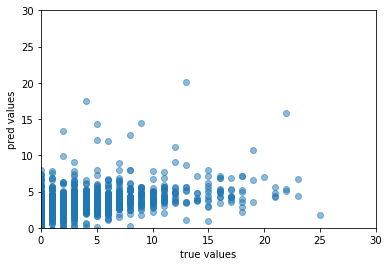

In [946]:
plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlim(0, 30)
plt.ylim(0, 30)
plt.xlabel("true values")
plt.ylabel("pred values")

## with backward selected features

In [947]:
X = sample.loc[:, sample.columns.isin(backward_selected_features)]
y = sample.loc[:, ['sum_DPQ']]

# split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state = RANDOM_SEED)


## STANDARDUIZE X_train
# scaler = StandardScaler().fit(X_train)
normalizer = Normalizer().fit(X_train)
X_scaled = normalizer.transform(X_train)


linear_model = LinearRegression()
linear_model = linear_model.fit(X_scaled, y_train)

# predict
y_pred = linear_model.predict(normalizer.transform(X_test))
r2 = r2_score(y_test, y_pred)

MSE = mean_squared_error(y_test, y_pred)
print(f'MSE (LM Backwards selected features): {MSE}\nr-squared: {r2}\nrmse: {np.sqrt(MSE)}')

MSE (LM Backwards selected features): 13.52667809864372
r-squared: 0.24179710261609388
rmse: 3.677863251759603


In [948]:
import statsmodels.api as sm
from scipy import stats

# plt.scatter(x = y_test, y = y_pred, alpha = 0.5)
# plt.xlim(0, 30)
# plt.ylim(0, 30)
# plt.xlabel("true values")
# plt.ylabel("pred values")


## with forward selection

In [949]:
X = sample.loc[:, sample.columns.isin(forward_selected_features)]
y = sample.loc[:, ['sum_DPQ']]

# split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state = RANDOM_SEED)


## STANDARDUIZE X_train
# scaler = StandardScaler().fit(X_train)
normalizer = Normalizer().fit(X_train)
X_scaled = normalizer.transform(X_train)


linear_model = LinearRegression()
linear_model = linear_model.fit(X_scaled, y_train)


# predict
y_pred = linear_model.predict(normalizer.transform(X_test))
r2 = r2_score(y_test, y_pred)

MSE = mean_squared_error(y_test, y_pred)
print(f'MSE (LM Forwards selected features): {MSE}\nr-squared: {r2}\nrmse: {np.sqrt(MSE)}')

MSE (LM Forwards selected features): 13.098190539756567
r-squared: 0.26581486265089294
rmse: 3.619142238121703


In [950]:
# plt.scatter(y_test, y_pred, alpha = 0.5)
# plt.xlim(-15, 30)
# plt.ylim(-15, 30)
# plt.xlabel("true values")
# plt.ylabel("pred values")


In [951]:
# scaler = StandardScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(test_features)

print(sample.loc[sample["sum_DPQ"].between(0,27/2)].shape)
print(sample.loc[sample["sum_DPQ"].between(27/2,28)].shape)

(4861, 22)
(207, 22)


# One hot Encoding sample DF

In [952]:
# from sklearn.preprocessing import OneHotEncoder

# #creating instance of one-hot-encoder
# encoder = OneHotEncoder(handle_unknown='ignore')

# #perform one-hot encoding on 'team' column 
# encoder_df = pd.DataFrame(encoder.fit_transform(sample[['RIAGENDR']]).toarray())
# encoder.categories

In [953]:
# subdata.loc[subdata["PAD680"].isnull()]

['RIAGENDR' 'DMDEDUC2' 'INDFMIN2' 'FIAPROXY' 'FSD032A' 'HUQ090' 'SLQ050'
 'SLQ120']


<AxesSubplot:>

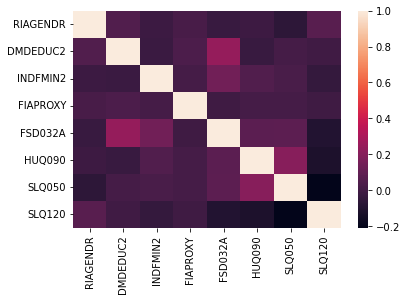

In [954]:
import seaborn as sb

corr = sample.loc[:,backward_selected_features].corr()
# sb.heatmap(corr, cmap="Blues", annot=True)

print(backward_selected_features)
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

# Lasso Regression

In [955]:

X = sample.loc[:, sample.columns.isin(forward_selected_features)]
y = sample.loc[:, ['sum_DPQ']]

# split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state = RANDOM_SEED)


clf = LassoCV(n_alphas = 500)
clf = clf.fit(X_train, y_train)

# predict
y_pred = clf.predict(X_test)
r2 = r2_score(y_test, y_pred)

MSE = mean_squared_error(y_test, y_pred)
print(f'MSE (LM Forward selected features): {MSE}\nr-squared: {r2}\nrmse: {np.sqrt(MSE)}')

C:\Users\samba\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MSE (LM Forward selected features): 13.185102235091994
r-squared: 0.2609432527301633
rmse: 3.6311296086881826


## 